# 1. 대중 교통 데이터 내려 받기
* BeautifulSoup 과 Selenium을 이용한 데이터 자동 다운 로드 구현
* 홈페이지 ( https://www.t-money.co.kr ) 에서 제공함
* 홈페이지 접속 >> 이용안내 클릭 >> 대중교통 통계자료 >> 5월 통계자료>> 첨부 파일 다운로드

In [28]:
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities

base_url = 'https://pay.tmoney.co.kr'
def newrequest(url):
    _proxies = {
      'http': 'http://12.26.226.2:8080',
      'https': 'http://12.26.226.2:8080',
    }
    _verify="semi_samsung.crt"
    return requests.get(url, proxies=_proxies, verify=_verify)

driver = webdriver.Remote(command_executor='http://12.36.185.100:4444/wd/hub', 
                          desired_capabilities=DesiredCapabilities.CHROME)

main_window_handle = None
info_window_handle = None

driver.implicitly_wait(3)
driver.get("https://www.t-money.co.kr")
driver.implicitly_wait(20)

# 현재 window handle을 저장
while not main_window_handle:
    main_window_handle = driver.current_window_handle

# 이용안내 클릭
driver.find_element_by_id('ugd').click()
driver.implicitly_wait(5)

# 이용안내 pop up windows로 이동하기 위해 info window 설정
while not info_window_handle:
    for handle in driver.window_handles:
        if handle != main_window_handle:
            info_window_handle = handle
            break
# 이용안내 pop up window 로 이동
driver.switch_to.window(info_window_handle)
html_src = driver.page_source

# 대중교통 통계자료 URL을 얻기 위해 BeautifulSoup 사용해서 파싱
soup = BeautifulSoup(html_src, 'html.parser')
pub_transportation = soup.select('#wrap > div.black_box.clfix > article.article_type03.link_list04.article_top > p:nth-child(1) > a')
target_url = base_url + pub_transportation[0].get('href')
print(target_url)

# 불필요한 창 닫기
driver.close()
driver.switch_to.window(main_window_handle)
driver.close()


https://pay.tmoney.co.kr/ncs/pct/ugd/ReadTrcrStstList.dev


In [30]:
import time
# 대중교통 통계자료 자료 게시판으로 가서 5월 통계 자료 다운로드 
driver = webdriver.Remote(command_executor='http://12.36.185.100:4444/wd/hub', 
                          desired_capabilities=DesiredCapabilities.CHROME)
driver.get(target_url)
driver.implicitly_wait(3)

# 5월 통계 자료 & 
driver.find_element_by_css_selector('#contents > div.tabletype03.tb_common.tb_notice.gap_20 > table > tbody > tr:nth-child(5) > td.a_left > a').click()
driver.implicitly_wait(3)
# 첨부파일 다운로드하기 
driver.find_element_by_css_selector('#contents > div.view_box > div.view_bot.clfix > dl.view_file.clfix > dd > a').click()
time.sleep(10)
driver.close()

print("파일 다운로드 완료")

파일 다운로드 완료


## 2. 유임 승차 비율이 높은 상위 5개 역을 출력하는 기능 구현
- 제공 : 지하철 유무임별 이용현황.csv 
- 유임 승차 비율 = 유임승차인원/전체승차인원

In [54]:
import pandas as pd

df = pd.read_csv("지하철 유무임별 이용현황.csv", encoding='cp949')

In [55]:
# type 변환
df['유임승차'] = df['유임승차'].apply(lambda x: x.replace(",","")).astype(int)
df['무임승차'] = df['무임승차'].apply(lambda x: x.replace(",","")).astype(int)

In [56]:
# 비율 추가
df['ratio'] = df.apply(lambda x: int(x['유임승차'])/(int(x['유임승차'])+int(x['무임승차'])),axis=1)

In [57]:
# 비율로 내림차순 정렬, 상위 5개 출력
df.sort_values('ratio', ascending=False).head(5)

,사용월,호선명,역ID,지하철역,유임승차,유임하차,무임승차,무임하차,작업일시,ratio
463,2020-05,6호선,2649,신내,6,0,0,0,2020-06-03 11:49:03,1.0
328,2020-05,경의선,1291,서울역,1,0,0,0,2020-06-03 11:49:03,1.0
192,2020-05,경원선,1022,창동,11,0,0,0,2020-06-03 11:49:03,1.0
237,2020-05,분당선,1031,복정,10,0,0,0,2020-06-03 11:49:03,1.0
330,2020-05,경의선,1297,검암,4,0,0,0,2020-06-03 11:49:03,1.0


## 3. 유임승차 인원이 가장 많은 역과 가장 적은 역의 아래 필드명을 레이터 차트로 출력하는 기능 구현
- 제공: 지하철 유무임별 이용현황.csv
- 출력 필드 : 유임승차, 유임하차, 무임승차, 무임하차

In [19]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
from matplotlib import font_manager
columnList = ['유임승차', '유임하차', '무임승차', '무임하차']
df = pd.read_csv("지하철 유무임별 이용현황.csv", encoding='cp949')
# type 변환
for c in columnList:
    df[c] = df[c].apply(lambda x: x.replace(",","")).astype(int)
df = df[columnList]

In [20]:
num_cols= len(columnList)
deg = [n / float(num_cols)*2*pi for n in range(num_cols)]
deg += deg[:1]

In [21]:
data_max = df.iloc[df['유임승차'].idxmax()].values.tolist()
data_max += data_max[:1]
data_min = df.iloc[df['유임승차'].idxmin()].values.tolist()
data_min += data_min[:1]

In [22]:
font_list = font_manager.findSystemFonts(fontpaths = None, fontext = 'ttf')
font_list[:]

['C:\\Windows\\Fonts\\lucon.ttf', 'C:\\Windows\\Fonts\\malgun.ttf']

In [23]:
print(mpl.matplotlib_fname())

C:\Anaconda\lib\site-packages\matplotlib\mpl-data\matplotlibrc


Malgun Gothic


Text(0.3, 0.3, '한글')

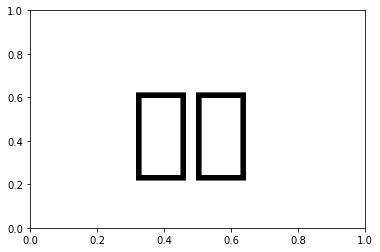

In [26]:
font_path = font_list[1]
font_name = font_manager.FontProperties(fname=font_path).get_name()
print(font_name)
plt.rc('font', family=font_name)
plt.rc('axes', unicode_minus=False)
plt.text(0.3, 0.3, '한글', size=100)

'C:\\Users\\ContainerAdministrator\\.matplotlib'

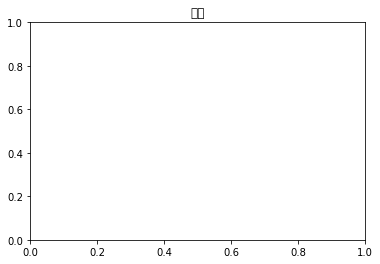

In [31]:
plt.figure().add_subplot().set_title('한글')
mpl.get_cachedir()

([<matplotlib.projections.polar.ThetaTick at 0x16c3fdf31f0>,
 [Text(0, 0, '유임승차'),
  Text(0, 0, '유임하차'),
  Text(0, 0, '무임승차'),
  Text(0, 0, '무임하차')])

C:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 50976 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 51076 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 49849 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 52264 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 54616 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 47924 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda\lib\site-package

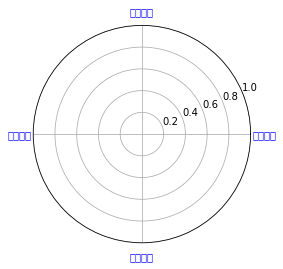

In [5]:
plt.rc('font', family='Malgun Gothic')
axis = plt.subplot(111, polar=True)
plt.xticks(deg[:-1], columnList, color='Blue', size=10)